In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flower-classification-with-tpus/sample_submission.csv
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/04-224x224-23

In [2]:
!pwd

/kaggle/working


In [3]:
!pip install -q -U albumentations

In [4]:
!pip install tensorflow-addons

In [5]:
!pip install -U --pre efficientnet

     |████████████████████████████████| 50 kB 1.4 MB/s eta 0:00:01


In [6]:
# Import Dependencies
import os
import re
import math
import numpy as np
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate, Blur,
)
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
tf.__version__

'2.4.1'

In [8]:
np.random.uniform()

0.34749590030406996

In [9]:
# Set number of items to pre-fetch to Autotune
AUTO = tf.data.experimental.AUTOTUNE

In [10]:
# Setup TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  8


In [11]:
# Since TPU's read data from a GCS Bucket only, load all data to GCS Bucket
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

In [12]:
# Configure Training Parameters
IMAGE_SIZE = [512, 512]
EPOCHS = 20
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [13]:
# Select the dataset to use for training
GCS_PATH_SELECT = {
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

# Selecting 512 x 512 images here
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

In [14]:
# Get filepaths for train, val and test set
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

# Adds more dataset to model training
SKIP_VALIDATION = True
if SKIP_VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES

In [15]:
# Sample Training TFRecord Path
TRAINING_FILENAMES[0]

'gs://kds-1d93f9f432691517cdc18eaca42e621644a47819b3b2b6af7a944868/tfrecords-jpeg-512x512/train/00-512x512-798.tfrec'

In [16]:
# Class Names
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'] 

## Visualization Utilities

In [17]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## Dataset Utilities

In [18]:
# Since the dataset is in the TFRecord format and all images inside that are in JPG format, we need a couple of helper functions
# 1. Load the TFRecord file
# 2. Read the Image, Label pairs from TFRecord Files
# 3. For images without labels [Test Data], read only images with their id's
# 4. Apply Data Augmentation

# HELPER FUNCTIONS
# Decode Images
def decode_image(image_data):
    # Decode the JPEG Image
    image = tf.image.decode_jpeg(image_data, channels=3)
    # Reshape the image to set size
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    
    # Return the decoded image
    return image

# Read and decode labeled tfrecord files [train/val]
def read_labeled_tfrecords(example):
    # Configuration for parsing a single, fixed-length input feature i.e. 
    # a single instance of (image, label)
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    # Parse out the data using the format
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    # Since the image is currently in a bytestring form, it needs to be decoded
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    
    # Return (image, label) pairs
    return image, label

# Read and decode unlabeled tfrecord files [test]
def read_unlabeled_tfrecords(example):
    # Configuration for parsing a single, fixed-length input feature i.e. 
    # a single instance of (image, label)
    # Since, no labels are present, we read in the image and it's id, no class
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    
    # Parse out the data using the format
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    # Since the image is currently in a bytestring form, it needs to be decoded
    image = decode_image(example['image'])
    idNum = example['id']
    
    # Return (image, id) pairs
    return image, idNum

In [19]:
# Function to Load Dataset
def load_dataset(fnames, labeled=True, ordered=False):
    # We read in the data in parallel and hence are not concerned about the order of it as we usually shuffle the data
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    
    # Read multiple TFRecord Files
    dataset = tf.data.TFRecordDataset(fnames, num_parallel_reads=AUTO)
    # Read data out of order, just as soon as it's read in
    dataset = dataset.with_options(ignore_order)
    # Read the (image, class) or (image, id) pairs from TFRecord files
    dataset = dataset.map(read_labeled_tfrecords if labeled else read_unlabeled_tfrecords, num_parallel_calls=AUTO)
    
    # Return (image, class) or (image, id) pairs depending on the dataset
    return dataset

In [28]:
# Helper Function

# Create Albumentation Augmentation Pipeline
transforms = Compose([
            Rotate(limit=40),
            RandomBrightness(limit=0.1),
            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
            Blur(p=0.5)
])

# Augmentation using albumentations
def aug_fn(image, img_size):
    data = {"image": image}
    # Apply transforms
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    return aug_img

# Function to perform Data Augmentation
def data_augmentation(image, label):
    aug_image = tf.numpy_function(func=aug_fn, inp=[image, IMAGE_SIZE[0]], Tout=tf.float32)
    
    # Return Augmented (image, label) pairs
    return aug_image, label

# Original Augment
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    # Random Flip Up/Down
    image = tf.image.random_flip_up_down(image)
    # Random Brightness
    image = tf.image.random_brightness(image, 0.1)
    
    # Random Augmentations
    if np.random.uniform() > 0.8:
        # Random Rotation
        image = tfa.image.rotate(image, 15.0)
        # Random Shear in x direction
        image = tfa.image.shear_x(image, 5.0, 0)
        # Random Shear in y direction
        image = tfa.image.shear_y(image, 5.0, 0)
    
    # Random Cutout
    image = tfa.image.random_cutout(tf.expand_dims(image, 0), (362, 102))
    image = tf.squeeze(image)
    # Random Contrast
    #image = tf.image.random_contrast(image, 0.2, 0.5)
    return image, label

In [29]:
# Helper Functions to get Train, Val, Test Datasets

# Function to load Training Data
def get_train_dataset(ordered=False):
    # Load Training Dataset
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, ordered=ordered)
    # Apply Augmentations
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    # Repeat Dataset for several epochs
    dataset = dataset.repeat()
    # Shuffle Dataset
    dataset = dataset.shuffle(2048)
    # Create a dataset batch
    dataset = dataset.batch(BATCH_SIZE)
    # Prefetch next batch of data while training
    dataset = dataset.prefetch(AUTO)
    
    return dataset

# Function to load Validation Data
def get_val_dataset(ordered=False):
    # Load Validation Dataset
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    # Create data batch
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    # Prefetch next batch of data while training
    dataset = dataset.prefetch(AUTO)
    
    return dataset

# Function to load Test Data
def get_test_dataset(ordered=False):
    # Load Test Dataset
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    # Apply Augmentations
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    # Load data batch
    dataset = dataset.batch(BATCH_SIZE)
    # Prefetch next batch of data
    dataset = dataset.prefetch(AUTO)
    
    return dataset

In [30]:
# Function to count number of images in a TFRecord
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [31]:
# Data Metrics
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = (1 - SKIP_VALIDATION) * count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
TEST_STEPS = -(-NUM_TEST_IMAGES // BATCH_SIZE)             # The "-(-//)" trick rounds up instead of down :-)

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 16465 training images, 0 validation images, 7382 unlabeled test images


## Dataset Visualization

In [32]:
# Evaluate Training Data
print("Training data shapes:")
# Take 3 batches of data from training set and evaluate
for image, label in get_train_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [101  74  49 ...  24   4  88]


In [33]:
# Evaluate Validation Data
print("Validation data shapes:")
# Take 3 batches of data from validation set and evaluate
for image, label in get_val_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())

Validation data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Validation data label examples: [67 47 47 ...  4 73 83]


In [34]:
# Evaluate Test Data
print("Test data shapes:")
# Take 3 batches of data from test set and evaluate
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U'))

Test data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Test data IDs: ['4fb5992b3' '92c33e670' 'bf54b2c66' ... 'b2a655d89' '46ccb6bd3' '6485b01ac']


## Visualize Dataset

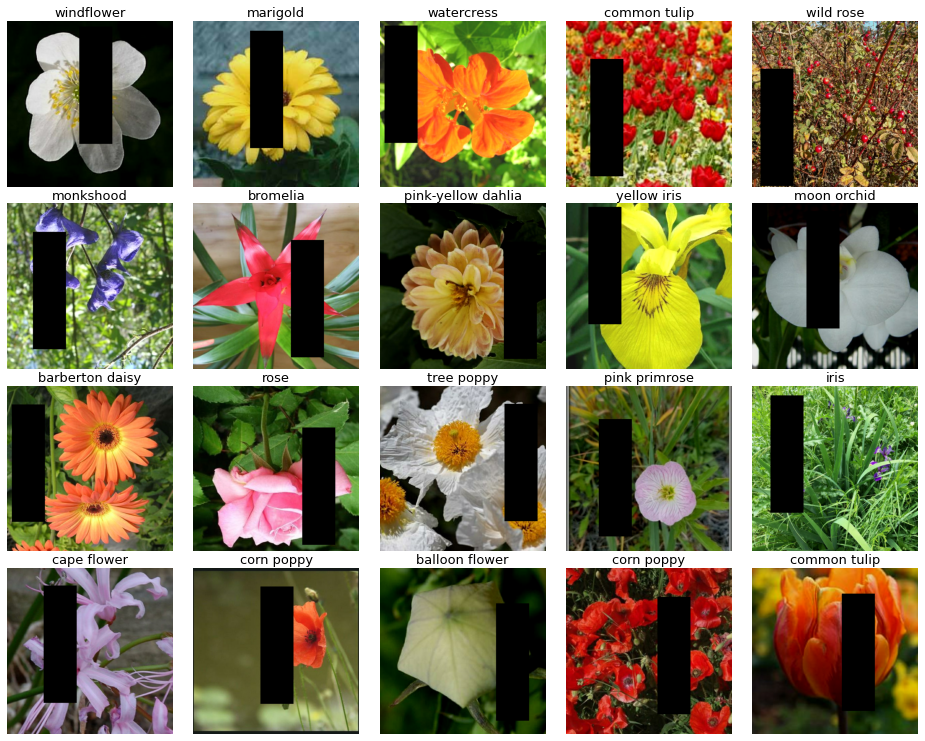

In [35]:
# Get a batch of data from training dataset
training_dataset = get_train_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

# Display the batch of training images
display_batch_of_images(next(train_batch))

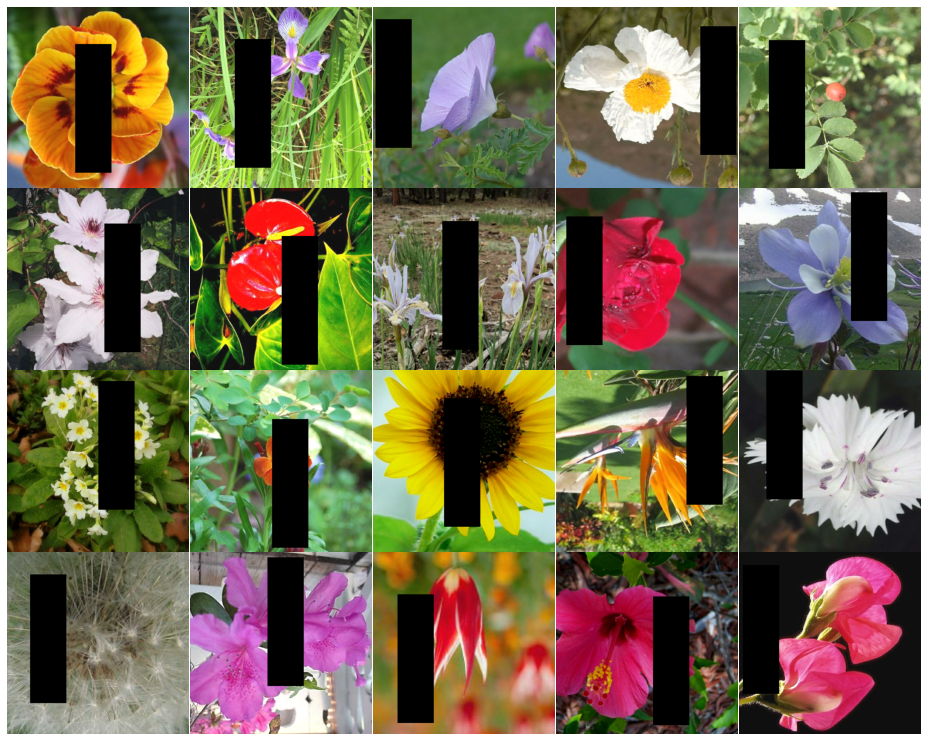

In [36]:
# Get a batch of Test Data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

# Display the batch of test images
display_batch_of_images(next(test_batch))

## Learning Rate Scheduler

Learning rate schedule: 1e-05 to 0.0004 to 2.72e-05


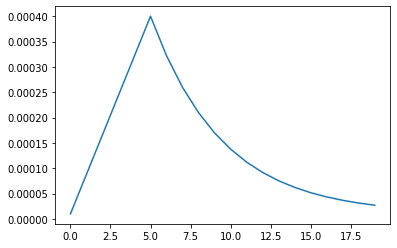

In [38]:
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

# Visualize Learning Rate Scheduler
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [39]:
checkpoint1 = tf.keras.callbacks.ModelCheckpoint('EfficientNet_flower_clf.h5', verbose=1, monitor='val_loss', mode='min', 
                                        save_best_only=True, save_weights_only=True)

checkpoint2 = tf.keras.callbacks.ModelCheckpoint('DenseNet_flower_clf.h5', verbose=1, monitor='val_loss', mode='min', 
                                        save_best_only=True, save_weights_only=True)

## Model Development

Here, we'll try out a couple of models and approaches.

1. Use VGG-16 pre-trained model
2. Use DenseNet-101/152 pre-trained model
3. Use EfficientNet-B0/B7 pre-trained model
4. Try an ensemble of models from above list

In [40]:
# Function to get VGG model
def get_vgg_model():
    # Get Image Pre-processing layer for VGG
    img_adjust_layer = tf.keras.layers.Lambda(lambda data: tf.keras.applications.vgg16.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3])
    # Get the pre-trained model without the classification output layer
    pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
    # Freeze model layers
    pretrained_model.trainable = False # False = transfer learning, True = fine-tuning
    
    # Setup the model
    model = tf.keras.Sequential([
        img_adjust_layer,
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    return model

In [41]:
def get_denseNet_model():
    img_adjust_layer = tf.keras.layers.Lambda(lambda data: tf.keras.applications.densenet.preprocess_input(tf.cast(data, tf.float32)), input_shape=[*IMAGE_SIZE, 3])
    # Get the pre-trained model without the classification output layer
    pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False)
    # Freeze model layers
    #pretrained_model.trainable = False # False = transfer learning, True = fine-tuning
    
    model = tf.keras.Sequential([
        img_adjust_layer,
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    return model

In [42]:
def get_efficeintNet_model():
    enet = efn.EfficientNetB7(
        input_shape=(512, 512, 3),
        weights='noisy-student',
        include_top=False
    )

    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    return model

## Training Model 1: EfficientNet-B7

In [47]:
with strategy.scope():
    # Get the model
    model1 = get_efficeintNet_model()
    
    # Compile the Model
    model1.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
        steps_per_execution=16
    )

In [48]:
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________
None


In [49]:
history1 = model1.fit(
    get_train_dataset(),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=None if SKIP_VALIDATION else get_validation_dataset(),
    callbacks=[lr_callback, checkpoint1])

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
128/128 [==============================] - 368s 3s/step - loss: 4.5932 - sparse_categorical_accuracy: 0.0436
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
128/128 [==============================] - 96s 748ms/step - loss: 3.6649 - sparse_categorical_accuracy: 0.2444
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
128/128 [==============================] - 96s 749ms/step - loss: 1.4745 - sparse_categorical_accuracy: 0.6579
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
128/128 [==============================] - 96s 749ms/step - loss: 0.6746 - sparse_categorical_accuracy: 0.8339
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
128/128 [==============================] - 96s 748ms/step - loss: 0.4797 - sparse_categorical_accuracy: 0.8791
Epoch 6/20

Epoch 00006: LearningRat

## Training Model 2: DenseNet-121

In [50]:
with strategy.scope():
    # Get the model
    model2 = get_denseNet_model()
    
    # Compile the Model
    model2.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
        steps_per_execution=16
    )

74842112/74836368 [==============================] - 1s 0us/step


In [51]:
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 512, 512, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, None, None, 1920)  18321984  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________
None


In [52]:
history2 = model2.fit(
    get_train_dataset(),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=None if SKIP_VALIDATION else get_validation_dataset(),
    callbacks=[lr_callback, checkpoint2])

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
128/128 [==============================] - 281s 2s/step - loss: 4.4141 - sparse_categorical_accuracy: 0.0699
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
128/128 [==============================] - 47s 365ms/step - loss: 2.1876 - sparse_categorical_accuracy: 0.5340
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
128/128 [==============================] - 47s 364ms/step - loss: 0.8659 - sparse_categorical_accuracy: 0.8151
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
128/128 [==============================] - 47s 365ms/step - loss: 0.5067 - sparse_categorical_accuracy: 0.8878
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
128/128 [==============================] - 47s 365ms/step - loss: 0.4009 - sparse_categorical_accuracy: 0.9074
Epoch 6/20

Epoch 00006: LearningRat

## Model Training Evaluation

In [54]:
# Model-1
# Plot model training curves
display_training_curves(history1.history['loss'], 'loss', 211)
display_training_curves(history1.history['sparse_categorical_accuracy'], 'accuracy', 212)

TypeError: display_training_curves() missing 1 required positional argument: 'subplot'

In [ ]:
# Model-2
# Plot model training curves
display_training_curves(history2.history['loss'], 'loss', 211)
display_training_curves(history2.history['sparse_categorical_accuracy'], 'accuracy', 212)

## Model Performance Evaluation

For evaluating the model performance, we'll use the following:

1. Create a Confusion Matrix to check for True Positives, False Positives, True Negatives and False Negatives.
2. Precision
3. Recall

In [55]:
!ls /kaggle/working/

__notebook_source__.ipynb


In [42]:
# Load Best Trained Model
# model.load_weights('/kaggle/working/EfficientNet_flower_clf.h5')

In [56]:
if not SKIP_VALIDATION:
    cmdataset = get_val_dataset(ordered=True)
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
    
    cm_probabilities1 = model1.predict(images_ds)
    cm_probabilities2 = model2.predict(images_ds)
    scores = []
    
    for alpha in np.linspace(0,1,100):
        cm_probabilities = alpha * cm_probabilities1 + (1 - alpha) * cm_probabilities2
        cm_predictions = np.argmax(cm_probabilities, axis=-1)
        scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))
        
    print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
    print("Predicted labels: ", cm_predictions.shape, cm_predictions)
    
    plt.plot(scores)
    best_alpha = np.argmax(scores)/100
    cm_probabilities = best_alpha * cm_probabilities1 + (1 - best_alpha) * cm_probabilities2
    cm_predictions = np.argmax(cm_probabilities, axis=-1)

else:
    best_alpha = 0.44

In [57]:
if not SKIP_VALIDATION:
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

## Make Predictions on Test Dataset using Test Time Augmentation [TTA]

In [60]:
# Get Prediction Probabilities from EfficientNet model
# Number of Test Time Augmentations to perform
TTA_NUM = 10
probabilities1 = []

for i in range(TTA_NUM):
    test_ds = get_test_dataset(ordered=True)
    print('Computing predictions...')
    test_images_ds = test_ds.map(lambda image, idnum: image)
    probabilities1.append(model1.predict(test_images_ds, steps=TEST_STEPS))

prob1 = np.mean(probabilities1,axis=0)

Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...


In [61]:
# Get Prediction Probabilities from DenseNet model
# Number of Test Time Augmentations to perform
TTA_NUM = 10
probabilities2 = []

for i in range(TTA_NUM):
    test_ds = get_test_dataset(ordered=True)
    print('Computing predictions...')
    test_images_ds = test_ds.map(lambda image, idnum: image)
    probabilities2.append(model2.predict(test_images_ds, steps=TEST_STEPS))

prob2 = np.mean(probabilities2,axis =0)

Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...
Computing predictions...


In [62]:
print("probb1: ", prob1)
print("probb2: ", prob2)

probb1:  [[4.5266739e-04 4.3168975e-04 1.5886484e-04 ... 8.7820750e-05 6.9716584e-04
  6.7259383e-04]
 [8.2605163e-04 9.2222559e-04 5.1587645e-04 ... 4.1076532e-04 6.6730655e-03
  1.6434419e-03]
 [5.9962913e-04 5.8649725e-04 3.1996233e-04 ... 2.2834765e-04 4.4615222e-03
  1.5540853e-03]
 ...
 [1.5650338e-03 1.1956989e-03 1.0317771e-03 ... 9.7103987e-04 9.1017019e-03
  4.5898790e-03]
 [2.1265508e-04 2.2928955e-04 9.7935132e-05 ... 4.5885648e-05 7.9253161e-01
  4.5066024e-04]
 [1.3283838e-03 6.9511763e-04 5.2999111e-04 ... 3.8499405e-04 9.9250469e-03
  1.2802056e-03]]
probb2:  [[1.2716503e-06 3.4051027e-07 1.9079967e-07 ... 3.4910894e-07 3.2940138e-06
  2.5334848e-06]
 [1.9874933e-07 1.9641649e-07 1.1991979e-07 ... 5.6343958e-07 1.1638131e-06
  7.7219022e-07]
 [2.0892023e-06 4.1006178e-06 4.8461814e-05 ... 7.8334625e-07 1.3371325e-06
  2.8084762e-06]
 ...
 [5.2000592e-05 2.0658701e-05 3.7269641e-05 ... 1.3110922e-05 1.6704734e-04
  5.3579725e-02]
 [5.8463738e-06 1.9500142e-06 8.6151056e-

In [63]:
# Calculate and Print Weighted Predictions of 2 models
prob = best_alpha * prob1 + (1 - best_alpha) * prob2
predictions = np.argmax(prob, axis=-1)
print("predictions: ", predictions)

predictions:  [ 67  28  83 ...  86 102  62]


In [64]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv

Generating submission.csv file...
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,83
00e4f514e,103
59d1b6146,46
8d808a07b,53
aeb67eefb,52
53cfc6586,29
aaa580243,82


## Visual Validation

In [67]:
# Get validation dataset
dataset = get_test_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

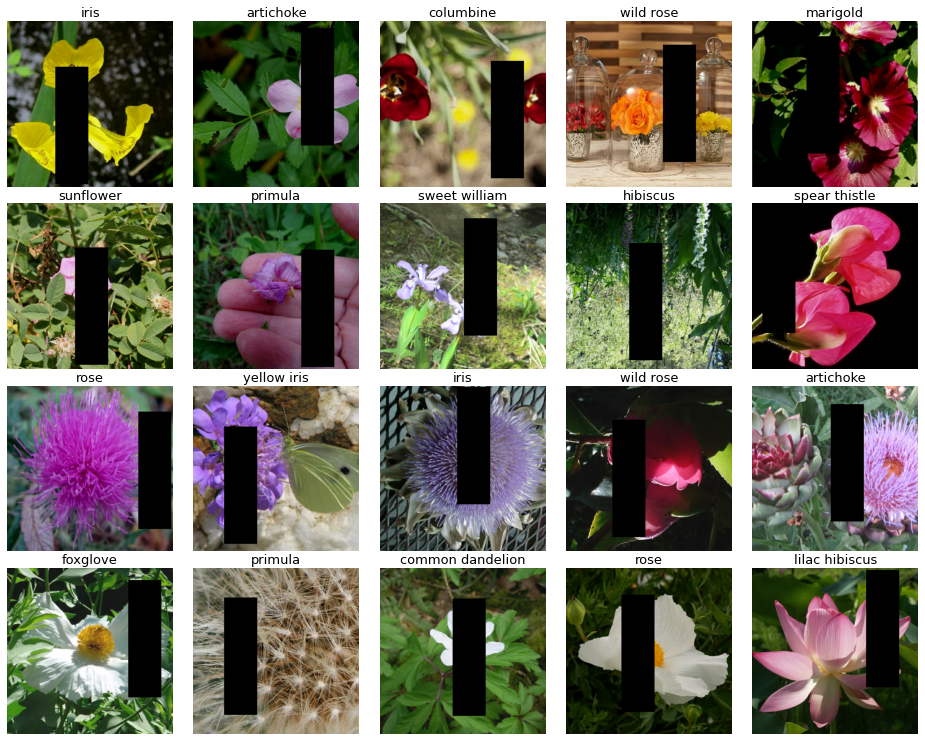

In [69]:
# Visualize Model Prdeictions
images, labels = next(batch)
predictions = np.argmax(prob, axis=-1)
display_batch_of_images((images, labels), predictions)